# Seminar 4 Part 1: REINFORCE

In this seminar, we will consider the random work problem detailed problem, implement the REINFORCE algorithm

## The random walk problem: 

Consider the following example with 7 states: 

F - A - B - C - D - E - S

Here, F and S corresponds to the terminal states. On each state, we can choose either to move to the left, or move to the right. Rewards is 0 if we move from E to S and -1 otherwise. The initial location is given by state C, in the middle. 

* You will apply the REINFORCE algorithm (P25, Lecture 8) to this example to compute an optimal policy. Specifically, since the action is binary, we consider using Example 3 to parametrize (P22, Lecture 8) the policy class. The feature function $\phi(s)$ can be set to a table lookup function, e.g., $\phi(s)=[I(s=s_1), I(s=s_2), \cdots, I(s=s_7)]$ where $(s_1,\cdots,s_7)$ corresponds to the state space. You may fix the step size $\alpha$ to 0.1. 

* Consider generating 1000 episodes to learn the optimal policy. In each episode, compute the return. This yields a total of 1000 returns. Repeat this procedure 100 times and compute the average return for each episode, aggregated over 100 replications. 

* As we have discussed in the lecture, the expected value of the policy score is equal to zero. As such, we can add a baseline term to the return $G_t$ to reduce the variance of the gradient. Under the current setting, the return is at most $-2$. We may replace $G_t$ in the REINFORCE algorithm with $G_t+2$. The resulting gradient is expected to have a smaller variance. Repeat the procedure in Step 2 for this algorithm and compute the average return for each of the 1000 episodes. 

* Plot the 2000 average returns obtained in Steps 2 and 3. 

<img  src=./graphs/randomwalk.png  width=750>

## First, let us review the REINFORCE algorithm

<img  src=./graphs/REINFORCE.png  width=750>

In our example, we combine a table lookup model with a logistic regression model to model $\pi$. Specifically, for each state $s$, we can model the probability of moving to the right (or to the left) as 
$$\pi(s,\textrm{right};\theta_s) = \frac{\exp(\theta_s)}{1+\exp(\theta_s)}.$$ 
With some calculations, it is easy to show that the policy score equals
\begin{align*}
    \nabla_{\theta_s} \log(\pi(s,\textrm{right};\theta_s))&=&1-\frac{\exp(\theta_s)}{1+\exp(\theta_s)}=\frac{1}{1+\exp(\theta_s)},\\
    \nabla_{\theta_s} \log(\pi(s,\textrm{left};\theta_s))&=&-\frac{\exp(\theta_s)}{1+\exp(\theta_s)}=-\frac{1}{1+\exp(-\theta_s)}.
\end{align*}
We will use these policy scores to update the policy parameter.

## Second, let us implement the random walk environment (we use similar code in Seminar 4)

In [1]:
# actions
left = 0
right = 1

class RandomWalk:
    def __init__(self, initial_state=3):
        self.initial_state = initial_state
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    # write step function that returns obs(next state), reward, is_done
    def step(self, action):
        if self.state == 5 and action == right:
            self.state += 1
            self.is_terminal = True
            self.reward = 0.0
        elif self.state == 1 and action == left:
            self.state -= 1
            self.is_terminal = True
            self.reward = -1.0
        else:
            if action == left:
                self.state -= 1
            else:
                self.state += 1
            self.is_terminal = False
            self.reward = -1.0

        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state

## Next, let us implement the REINFORCE algorithm

In [2]:
import numpy as np

import warnings

warnings.filterwarnings("ignore")

## create random walk environment:
initial_state = 3
env = RandomWalk(initial_state)

## define the policy
def policy(theta):
    prob_right = np.exp(theta) / (1 + np.exp(theta))
    a = np.random.binomial(n=1, p=prob_right, size=1)
    return a

alpha = 0.1  # step size
nruns = 100
episodes = 1000
rewards = np.zeros((episodes, 2))
for r in range(nruns):
    np.random.seed(r)
    
    ## Method I: without baseline term
    Theta = np.zeros(7)  # initial parameter of policy
    for i in range(episodes):
        state = env.reset()
        done = False

        ## Monte Carlo
        g = 0.0
        sar = []
        while not done:
            a = policy(Theta[state])
            next_state, r, done = env.step(a)
            sar.append([state, a, r])
            g += r
            state = next_state
        rewards[i, 0] += g

        ## REINFORCE update
        for state, a, r in sar:
            theta = Theta[state]
            if a == 1:
                Theta[state] += alpha * g * (1 / (1 + np.exp(theta)))
            else:
                Theta[state] -= alpha * g * (1 / (1 + np.exp(-theta)))
            g = g - r

    ## Method II: with baseline term
    baseline = -2
    Theta = np.zeros(7)
    for i in range(episodes):
        state = env.reset()
        done = False

        ## Monte Carlo
        g = 0.0
        sar = []
        while not done:
            a = policy(Theta[state])
            next_state, r, done = env.step(a)
            sar.append([state, a, r])
            g += r
            state = next_state
        rewards[i, 1] += g

        ## REINFORCE update
        for state, a, r in sar:
            theta = Theta[state]
            if a == 1:
                Theta[state] += alpha * (g - baseline) * (1 / (1 + np.exp(theta)))
            else:
                Theta[state] -= alpha * (g - baseline) * (1 / (1 + np.exp(-theta)))
            g = g - r

rewards = rewards / nruns

In [3]:
np.transpose(rewards)

array([[-7.18, -8.62, -8.41, ..., -2.28, -2.26, -2.26],
       [-8.82, -7.63, -6.88, ..., -2.13, -2.11, -2.11]])

In [4]:
Theta

array([ 0.        , -1.60073276, -1.39920925,  4.82888077,  5.37110908,
        5.29267489,  0.        ])

## Finally, let us visualise these rewards

In [5]:
import matplotlib.pyplot as plt
def plot_return(rewards):
    plt.figure(figsize=(8, 6), dpi=80)
    for a in rewards:
        plt.plot(a, linewidth=3)
    plt.xlabel('Episode')
    plt.ylim(-5, 0)
    plt.ylabel('Rewards')
    legend_str = ["G", "G+2"]
    plt.legend(legend_str)
    plt.show()

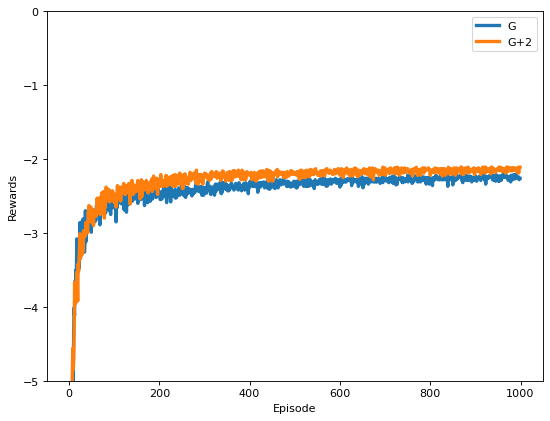

In [6]:
plot_return(np.transpose(rewards))